Episode 1: Total reward = 10.0
Episode 2: Total reward = 14.0
Episode 3: Total reward = 19.0
Episode 4: Total reward = 23.0
Episode 5: Total reward = 13.0
Episode 6: Total reward = 14.0
Episode 7: Total reward = 22.0
Episode 8: Total reward = 19.0
Episode 9: Total reward = 12.0
Episode 10: Total reward = 9.0
Episode 11: Total reward = 26.0
Episode 12: Total reward = 12.0
Episode 13: Total reward = 13.0
Episode 14: Total reward = 14.0
Episode 15: Total reward = 8.0
Episode 16: Total reward = 13.0
Episode 17: Total reward = 9.0
Episode 18: Total reward = 11.0
Episode 19: Total reward = 12.0
Episode 20: Total reward = 9.0
Episode 21: Total reward = 8.0
Episode 22: Total reward = 12.0
Episode 23: Total reward = 11.0
Episode 24: Total reward = 11.0
Episode 25: Total reward = 10.0
Episode 26: Total reward = 11.0
Episode 27: Total reward = 9.0
Episode 28: Total reward = 12.0
Episode 29: Total reward = 9.0
Episode 30: Total reward = 14.0
Episode 31: Total reward = 10.0
Episode 32: Total reward

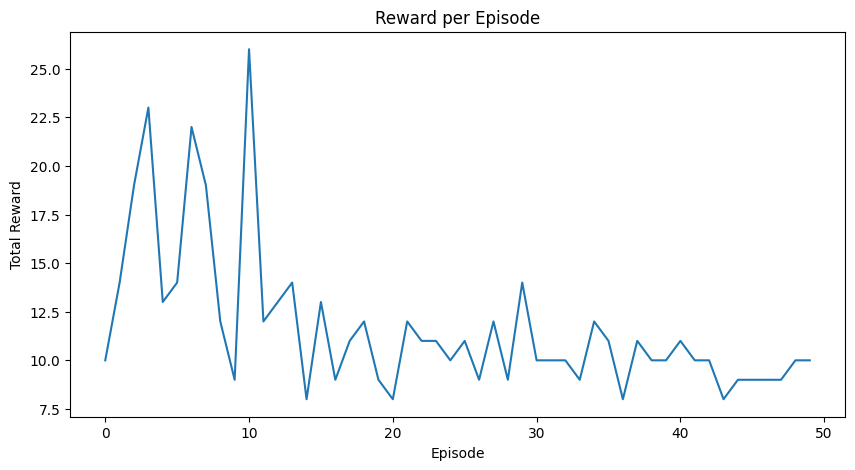

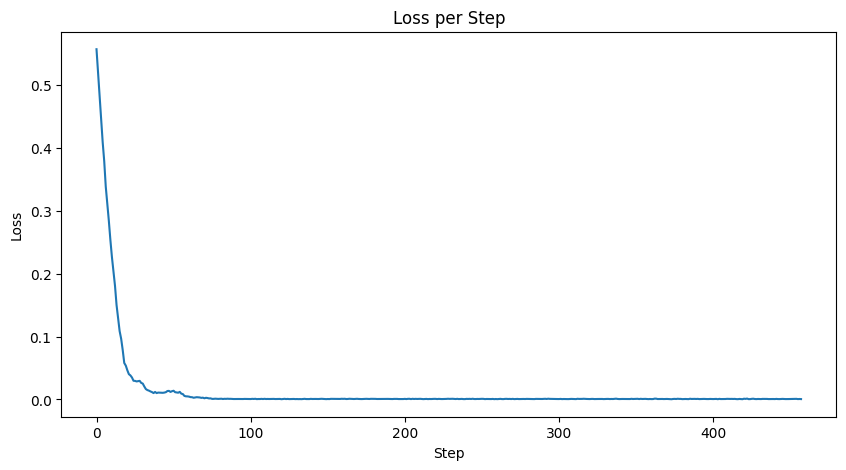

In [6]:
import gym
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple, deque
from itertools import count
import math
import matplotlib.pyplot as plt

# 设置环境
env = gym.make('CartPole-v1')

# GPU或CPU设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 命名元组存储转移
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# 经验回放
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Randomly sample a batch of transitions"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN网络模型
class DQN(nn.Module):
    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, outputs)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# DQN Agent
class DQNAgent:
    def __init__(self):
        self.n_actions = env.action_space.n
        self.policy_net = DQN(env.observation_space.shape[0], self.n_actions).to(device)
        self.target_net = DQN(env.observation_space.shape[0], self.n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters())
        self.memory = ReplayMemory(10000)
        self.steps_done = 0
        self.EPS_START = 0.9
        self.EPS_END = 0.05
        self.EPS_DECAY = 200
        self.BATCH_SIZE = 128
        self.GAMMA = 0.999

    def select_action(self, state):
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
                        math.exp(-1. * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1
        if random.random() > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        loss = nn.SmoothL1Loss()(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

# 主训练循环
def main():
    num_episodes = 50
    agent = DQNAgent()
    rewards = []
    losses = []

    for i_episode in range(num_episodes):
        state = env.reset()
        state = torch.tensor([state], device=device, dtype=torch.float32)
        total_reward = 0

        for t in count():
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action.item())
            total_reward += reward
            reward = torch.tensor([reward], device=device)

            if not done:
                next_state = torch.tensor([next_state], device=device, dtype=torch.float32)
            else:
                next_state = None

            agent.memory.push(state, action, next_state, reward)
            state = next_state

            loss = agent.optimize_model()
            if loss is not None:
                losses.append(loss)

            if done:
                break

        rewards.append(total_reward)
        print(f"Episode {i_episode+1}: Total reward = {total_reward}")

    plt.figure(figsize=(10,5))
    plt.plot(rewards)
    plt.title('Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(losses)
    plt.title('Loss per Step')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.show()

if __name__ == '__main__':
    main()

In [1]:
!pip install gym[accept-rom-license,atari]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 32.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=beb0dc68ec73dc2bb7bc21d4ffc1de42dcc3de3945516baf236c87b41580b561
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.9.0
    Uninstalling ale-py-0.9.0:
      Successfully uninstalled ale-py-0.9.0


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment Breakout-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommende

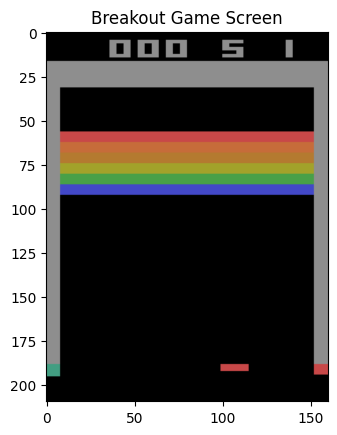

In [2]:
import gym

# 创建并初始化环境
env = gym.make('Breakout-v0')
env.reset()

# 执行一个动作 (0) 并获取反馈
action = 0  # 'NOOP'
observation, reward, done, info = env.step(action)

# 显示游戏屏幕的观察结果
import matplotlib.pyplot as plt

plt.imshow(env.render(mode='rgb_array'))
plt.title("Breakout Game Screen")
plt.show()

# 游戏结束时重置环境
if done:
    env.reset()

# 关闭环境
env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment Breakout-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns 

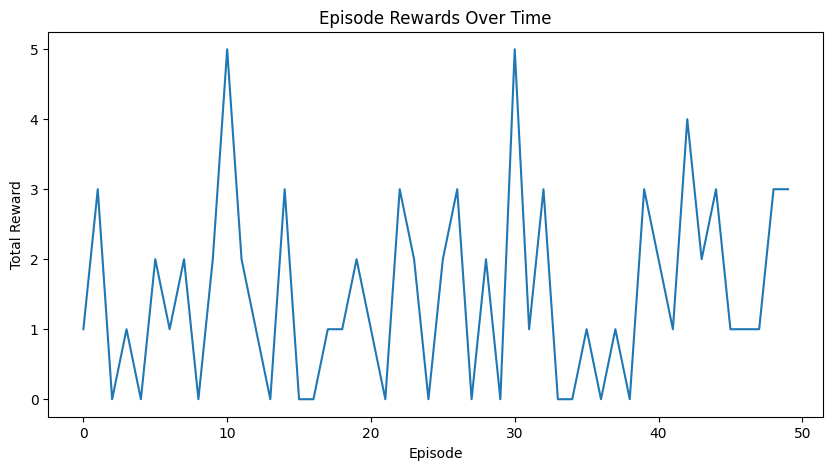

In [7]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple, deque
from itertools import count
from torchvision import transforms
import math
import matplotlib.pyplot as plt

# 设置环境
env = gym.make('Breakout-v0').unwrapped

# GPU或CPU设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 命名元组存储转移
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# 经验回放
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# 预处理管道
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((40, 40)),
    transforms.ToTensor()
])

def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return transform(screen).unsqueeze(0).to(device)

# DQN网络模型
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        self.head = nn.Linear(convh * convw * 32, outputs)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

# DQN Agent
class DQNAgent:
    def __init__(self):
        init_screen = get_screen()
        _, _, screen_height, screen_width = init_screen.shape
        self.n_actions = env.action_space.n
        self.policy_net = DQN(screen_height, screen_width, self.n_actions).to(device)
        self.target_net = DQN(screen_height, screen_width, self.n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters())
        self.memory = ReplayMemory(10000)
        self.steps_done = 0
        self.EPS_START = 0.9
        self.EPS_END = 0.05
        self.EPS_DECAY = 200
        self.BATCH_SIZE = 128
        self.GAMMA = 0.99

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
                        math.exp(-1. * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        loss = nn.SmoothL1Loss()(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# 主训练循环
def main():
    num_episodes = 50
    episode_rewards = []  # 用于记录每个episode的奖励
    agent = DQNAgent()
    for i_episode in range(num_episodes):
        env.reset()
        total_reward = 0
        last_screen = get_screen()
        current_screen = get_screen()
        state = current_screen - last_screen
        for t in count():
            action = agent.select_action(state)
            _, reward, done, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            total_reward += reward.item()

            last_screen = current_screen
            current_screen = get_screen()
            if not done:
                next_state = current_screen - last_screen
            else:
                next_state = None

            agent.memory.push(state, action, next_state, reward)
            state = next_state

            agent.optimize_model()
            if done:
                episode_rewards.append(total_reward)
                break

    plt.figure(figsize=(10,5))
    plt.plot(episode_rewards)
    plt.title('Episode Rewards Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()

if __name__ == '__main__':
    main()